In [1]:
#################################################################
### NNUNET WSI INFERENCE WITH HALF OVERLAP
#################################################################
# nnUNet by default does half overlap if the given patch is bigger than the model's patch size.
# This means that on the borders there is no or 1x overlap (1 or 2 predictions),
# while in the inside there are 4 predictions for each pixel.

# In this version of nnUNet WSI inference, we crop this border off the sampled patch, and only write the inner part
# This approach becomes more efficient if bigger patches are sampled, because this increases the inner/outer ratio
# To prevent inference on large empty patches we add a check if we can remove rows and columns,
# while preserving the half overlap of nnUNet's sliding window approach

# In this file we will also auto-configure the config and files yamls ;)
#################################################################

#################################################################
### Imports
#################################################################
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.interoperability.asap.imagewriter import WholeSlideMaskWriter
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
# from nnunet.training.model_restore import load_model_and_checkpoint_files
import os
import torch
from wholeslidedata.samplers.utils import crop_data
import yaml
from wholeslidedata.image.wholeslideimage import WholeSlideImage
import time

from nnunetv2.utilities.file_path_utilities import load_json
from nnunetv2.training.nnUNetTrainer.variants.pathology.nnUNetTrainer_custom_dataloader_test import nnUNetTrainer_custom_dataloader_test
from nnunetv2.paths import nnUNet_results, nnUNet_raw
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

#################################################################
### Functions and utilities
#################################################################
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"


def convert_path(path, to=current_os):
    """
    This function converts paths to the format of the desired platform.
    By default it changes paths to the platform you are cyurerntly using.
    This way you do not need to change your paths if you are executing your code on a different platform.
    It may however be that you mounted the drives differently.
    In that case you may need to change that in the code below.
    """
    if to in ["w", "win", "windows"]:
        path = path.replace("/mnt/pa_cpg", "Y:")
        path = path.replace("/data/pathology", "Z:")
        path = path.replace("/mnt/pa_cpgarchive1", "W:")
        path = path.replace("/mnt/pa_cpgarchive2", "X:")
        path = path.replace("/", "\\")
    if to in ["u", "unix", "l", "linux"]:
        path = path.replace("Y:", "/mnt/pa_cpg")
        path = path.replace("Z:", "/data/pathology")
        path = path.replace("W:", "/mnt/pa_cpgarchive1")
        path = path.replace("X:", "/mnt/pa_cpgarchive2")
        path = path.replace("\\", "/")
    return path


def norm_01(x_batch): # Use this for models trained on 0-1 scaled data
    x_batch = x_batch / 255
    x_batch = x_batch.transpose(3, 0, 1, 2)
    return x_batch

# def z_norm(x_batch): # use this for default nnunet models, using z-score normalized data
#     mean = x_batch.mean(axis=(-2,-1), keepdims=True)
#     std = x_batch.std(axis=(-2,-1), keepdims=True)
#     x_batch = ((x_batch - mean) / (std + 1e-8))
#     x_batch = x_batch.transpose(3, 0, 1, 2)
#     return x_batch


# def ensemble_softmax_list(trainer, params, x_batch):
#     softmax_list = []
#     for p in params:
#         trainer.load_checkpoint_ram(p, False)
#         softmax_list.append(
#             trainer.predict_preprocessed_data_return_seg_and_softmax(x_batch.astype(np.float32), verbose=False,
#                                                                      do_mirroring=False, mirror_axes=[])[
#                 -1].transpose(1, 2, 3, 0).squeeze())
#     return softmax_list

def ensemble_softmax_list(predictor, x_batch):
    logits_list = predictor.get_logits_list_from_preprocessed_data(x_batch)
    softmax_list = [trainer.apply_inference_nonlin(logits) for logits in logits_list]
    return softmax_list

def array_to_formatted_tensor(array):
    array = np.expand_dims(array.transpose(2, 0, 1), 0)
    return torch.tensor(array)

# def softmax_list_and_mean_to_uncertainty(softmax_list, softmax_mean):
#     loss = torch.nn.CrossEntropyLoss(reduction='none')
#     uncertainty_loss_per_pixel_list = []
#     for softmax in softmax_list:
#         log_softmax = np.log(softmax + 0.00000001)
#         uncertainty_loss_per_pixel = loss(array_to_formatted_tensor(log_softmax),
#                                           array_to_formatted_tensor(softmax_mean))
#         uncertainty_loss_per_pixel_list.append(uncertainty_loss_per_pixel)
#     uncertainty = torch.cat(uncertainty_loss_per_pixel_list).mean(dim=0)
#     return uncertainty

def softmax_list_and_mean_to_uncertainty(softmax_list, softmax_mean):
    loss = torch.nn.CrossEntropyLoss(reduction='none')
    uncertainty_loss_per_pixel_list = []
    for softmax in softmax_list:
        log_softmax = np.log(softmax + 0.00000001)
        uncertainty_loss_per_pixel = loss(array_to_formatted_tensor(log_softmax),
                                          array_to_formatted_tensor(softmax_mean))
        uncertainty_loss_per_pixel_list.append(uncertainty_loss_per_pixel)
    uncertainty = torch.cat(uncertainty_loss_per_pixel_list).mean(dim=0)
    return uncertainty


def get_trim_indexes(y_batch):
    """
    Using the y_mask / tissue-background mask we can check if there are
    full empty rows and columns with a width of half the model patch size.
    We check this in half model patch size increments because otherwise
    we screw up the half overlap approach from nnunet (resulting in inconsistent
    overlap thoughout the WSI).
    We will still need 1 row or column that is empty to make sure the parts that
    do have tissue have 4x overlap
    """
    y = y_batch[0]
    r_is_empty = [not y[start:end].any() for start, end in zip(half_patch_size_start_idxs, half_patch_size_end_idxs)]
    c_is_empty = [not y[:, start:end].any() for start, end in zip(half_patch_size_start_idxs, half_patch_size_end_idxs)]

    empty_rs_top = 0
    for r in r_is_empty:
        if r == True:
            empty_rs_top += 1  # count empty rows
        else:
            trim_top_half_idx = empty_rs_top - 1  # should always include a single empty row, since we need the overlap
            trim_top_half_idx = np.clip(trim_top_half_idx, 0, None)  # cannot select regiouns outside sampled patch
            trim_top_idx = half_patch_size_start_idxs[trim_top_half_idx]
            break

    empty_rs_bottom = 0
    for r in r_is_empty[::-1]:
        if r == True:
            empty_rs_bottom += 1
        else:
            trim_bottom_half_idx = empty_rs_bottom - 1
            trim_bottom_half_idx = np.clip(trim_bottom_half_idx, 0, None)
            trim_bottom_idx = half_patch_size_end_idxs[::-1][trim_bottom_half_idx]  # reverse index
            break

    empty_cs_left = 0
    for c in c_is_empty:
        if c == True:
            empty_cs_left += 1
        else:
            trim_left_half_idx = empty_cs_left - 1
            trim_left_half_idx = np.clip(trim_left_half_idx, 0, None)
            trim_left_idx = half_patch_size_start_idxs[trim_left_half_idx]
            break

    empty_cs_right = 0
    for c in c_is_empty[::-1]:
        if c == True:
            empty_cs_right += 1
        else:
            trim_right_half_idx = empty_cs_right - 1
            trim_right_half_idx = np.clip(trim_right_half_idx, 0, None)
            trim_right_idx = half_patch_size_end_idxs[::-1][trim_right_half_idx]
            break

    # print(trim_top_half_idx, trim_bottom_half_idx, trim_left_half_idx, trim_right_half_idx)
    # print(trim_top_idx, trim_bottom_idx, trim_left_idx, trim_right_idx)
    return trim_top_idx, trim_bottom_idx, trim_left_idx, trim_right_idx


def find_matches(img_folder, match_folder, img_extension='', match_extension='', match_contains='', exact_match=False):
    img_folder = convert_path(img_folder)
    img_files = [item for item in os.listdir(img_folder) if
                 os.path.isfile(os.path.join(img_folder, item)) and item.endswith(img_extension)]

    match_folder = convert_path(match_folder)
    match_files = [item for item in os.listdir(match_folder) if os.path.isfile(os.path.join(match_folder, item))]

    # Match and optional filter
    if exact_match:
        assert match_extension != '', 'exact_match needs a match extension to verify if img stem + match_extension == match filename'
        img_match_paths = [(os.path.join(img_folder, img_file),  # add wsi folder in front
                            os.path.join(match_folder, match_file))  # add xml folder in front
                           for img_file in img_files  # loop over wsi folder files
                           for match_file in match_files  # loop over filtered annotaion files
                           if match_file.split(convert_path('/'))[-1].startswith(
                img_file.split(convert_path('/'))[-1].split('.')[
                    0])  # only return if bg file starts with img file name (without suffix)
                           and (match_file == img_file.split('.')[0] + match_extension)  # exact match
                           and match_contains in match_file.split(convert_path('/'))[
                               -1]]  # only return if match contains match_contains

    else:
        img_match_paths = [(os.path.join(img_folder, img_file),  # add wsi folder in front
                            os.path.join(match_folder, match_file))  # add xml folder in front
                           for img_file in img_files  # loop over wsi folder files
                           for match_file in match_files  # loop over filtered annotaion files
                           if match_file.split(convert_path('/'))[-1].startswith(
                img_file.split(convert_path('/'))[-1].split('.')[
                    0])  # only return if bg file starts with img file name (without suffix)
                           and match_contains in match_file.split(convert_path('/'))[
                               -1]]  # only return if match contains match_contains

    # Checks and prints
    if len(img_match_paths) > 0:
        matched_img_paths, _ = zip(*img_match_paths)
        matched_img_files = [img_path.split(convert_path('/'))[-1] for img_path in matched_img_paths]
        unmatched = [img_file for img_file in img_files if img_file not in matched_img_files]
        matches = [img_file for img_file in matched_img_files if
                   img_file in img_files]  # this captures multiple matches per img_file
        if len(unmatched) > 0:
            print(f'{len(unmatched)} files were not machted:\n', unmatched)
        else:
            print('All image files were matched')
        if len(set(matches)) < len(matches):
            print('Some matched image files have multiple matches')
            raise Exception('Ambiguous')
        if len(matches) == len(set(matches)):
            print('Each matched image file has a single match')
    else:
        print('No matches')
    print('\n')
    return img_match_paths

def make_files_yml_and_return_matches_to_run(matches, files_yml_output_path, output_folder):
    """
    The whole pipeline is costructed in such a way that a <name>_runtime.txt file is created once a python script started to work on this WSI + mask match. This means that this file should not be processed anymore by another python script that is run in parralel (also doesnt need to be copied to the local machine (chis is the case on our computing cluster))
    """
    runtime_stems = [file[:-12] for file in os.listdir(output_folder) if file.endswith('_runtime.txt')]
    imgs, _ = zip(*matches)
    img_stems = [Path(file).stem for file in imgs]
    matches_to_run_idx = [i for i in range(len(img_stems)) if img_stems[i] not in runtime_stems]
    matches_to_run = [matches[i] for i in matches_to_run_idx]
    
    yaml_file = {"validation": []}
    for wsi, wsa in matches_to_run:
        # print(wsi, wsa)
        # 1/0
        yaml_file["validation"].append({"wsi": {"path": convert_path(str(wsi), to='linux')},
                                        "wsa": {"path": convert_path(str(wsa), to='linux')}})
    with open(convert_path(files_yml_output_path), 'w') as f:
        yaml.dump(yaml_file, f)
        print('CREATED FILES YAML:', files_yml_output_path)

    return matches_to_run

def get_closest_spacing(spacing_value):
    possible_spacings = [0.25, 0.5, 1, 2, 4, 8, 16]
    closest = min(possible_spacings, key=lambda x:abs(x-spacing_value))
    return closest

#################################################################
### LOAD MODEL, change your model here
#################################################################
trainer_results_folder = '/data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_results/Dataset004_TIGER_split/nnUNetTrainer_custom_dataloader_test__nnUNetWholeSlideDataPlans__2d'
plans_dict = load_json(os.path.join(trainer_results_folder, 'plans.json'))
dataset_dict = load_json(os.path.join(trainer_results_folder, 'dataset.json'))

trainer = nnUNetTrainer_custom_dataloader_test(plans_dict, '2d', 0, dataset_dict) # we need a trainer for a single fold to make use of its inbuilt functions

predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_gpu=True,
    device=torch.device('cuda', 0),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)

predictor.initialize_from_trained_model_folder(
    trainer_results_folder,
    use_folds=(0, 1, 2, 3, 4),
    checkpoint_name='checkpoint_best.pth',
)


# trainer, params = load_model_and_checkpoint_files(model_base_path, folds, mixed_precision=mixed_precision,
#                                                   checkpoint_name=checkpoint_name)

norm = norm_01 #z_norm if (('score' in trainer_name) or ('default' in trainer_name)) else norm_01


#################################################################
### CONFIGS AND PREP, change your settings here
#################################################################
# check output folder name well, this is where we will store the WSI inference files
# output_folder = Path('/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task024_TIGER_WSI')
output_folder = Path('/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/V2_Task004_TIGER_test')
# output_folder = Path('/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task024_TIGER_WSI/ignore0')

# f"/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/{task_name}/WSI_inference/{trainer_name}/{dataset_name}_borderless")
os.makedirs(output_folder, exist_ok=True)

dataset_name = 'V2_TIGER' # name that gets added to folder names and file names

# We now make the config and file yamls dynamically, add the file names here
files_yml_output_filename = f"wsi_borderless_inference_files_{dataset_name}.yml"
config_yml_output_filename = f"wsi_borderless_inference_config_{dataset_name}.yml"
files_yml_output_path = convert_path(rf'Z:\projects\pathology-lung-TIL\pathology-lung-TIL\code\config_files\{files_yml_output_filename}')
config_yml_output_path = convert_path(rf'Z:\projects\pathology-lung-TIL\pathology-lung-TIL\code\config_files\{config_yml_output_filename}')


### Make files yaml
# Enter the folder with the images/wsi and the tissue/bg masks here
# Specify the name of the files yaml

TIGER_test_wsi = convert_path(r'Z:\projects\tiger\new_structure\test-leaderboard-1\experimental-test-set\images')
TIGER_test_bg = convert_path(r'Z:\projects\tiger\new_structure\test-leaderboard-1\experimental-test-set\roi-masks')
image_anno_TIGER_test = find_matches(TIGER_test_wsi, TIGER_test_bg)

# TIGER_test_wsi = convert_path(r'Z:\projects\tiger\new_structure\test-leaderboard-1\final-test-set\images')
# TIGER_test_bg = convert_path(r'Z:\projects\tiger\new_structure\test-leaderboard-1\final-test-set\roi-masks')
# image_anno_TIGER_test = find_matches(TIGER_test_wsi, TIGER_test_bg)

matches = image_anno_TIGER_test[:1] ##################################################################################################################################
matches = make_files_yml_and_return_matches_to_run(matches, files_yml_output_path, output_folder)
###

### Make config yaml
# Added hints for construction of config file if you want to do it yourself
spacing = 0.5 # spacing for batch_shape spacing and annotation_parser output_spacing (leave its processing spacing on 4 or higher)

model_patch_size = 512 # input size of model (should be square)
half_model_patch_size=int(model_patch_size/2)

sampler_patch_size = 3 * model_patch_size
assert sampler_patch_size % (model_patch_size/2) == 0 # needed for correct half overlap

# due to half overlap there is half the model patch size without overlap on all 4 sides of the sampled patch
output_patch_size = sampler_patch_size - 2 * half_model_patch_size # use this as your annotation_parser shape
# Note that for this approach we need a CenterPointSampler, and center: True in the patch_sampler and patch_label_sampler

tissue_mask_spacing = get_closest_spacing(WholeSlideImage(matches[0][1]).spacings[0])
tissue_mask_ratio = tissue_mask_spacing/spacing

template = convert_path(r"Z:\projects\pathology-lung-TIL\pathology-lung-TIL\code\config_files\templates\borderless_config_v2.yml")

with open(template) as f:
    config_yml_str = str(yaml.safe_load(f))

replace_dict = {
    "'auto_files_yml'" : files_yml_output_path,
    "'auto_sampler_patch_size'" : sampler_patch_size,
    "'auto_spacing'" : spacing,
    "'auto_tissue_mask_spacing'" : tissue_mask_spacing,
    "'auto_tissue_mask_ratio'" : tissue_mask_ratio,
    "'auto_output_patch_size'" : output_patch_size
}

print('\nAuto configuring CONFIG YAML. Replacing template placeholders:')
for k, v in replace_dict.items():
    print('\t', k, v)
    config_yml_str = config_yml_str.replace(k, str(v))

config_yml = yaml.safe_load(config_yml_str)

with open(convert_path(config_yml_output_path), 'w') as f:
    yaml.dump(config_yml, f)
    print('CREATED CONFIG YAML:', config_yml_output_filename)

# Some variable settings you can ignore
mode = "validation"
image_path = None
previous_file_key = None
files_exist_already = None  # not sure if needed
plot = False
# following is later used to check if we can remove big empty parts of the sampled patch before inference
sampler_patch_size_range = list(range(sampler_patch_size))
half_patch_size_start_idxs = sampler_patch_size_range[0::half_model_patch_size]
half_patch_size_end_idxs = [idx + half_model_patch_size for idx in half_patch_size_start_idxs]



nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_raw
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_preprocessed
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nn

In [2]:
matches

[('/data/pathology/projects/tiger/new_structure/test-leaderboard-1/experimental-test-set/images/TC_S01_P000132_C0001_B101.tif',
  '/data/pathology/projects/tiger/new_structure/test-leaderboard-1/experimental-test-set/roi-masks/TC_S01_P000132_C0001_B101_roi_mask.tif')]

In [3]:
sampler_patch_size = 1536
border_size = 256

# Create an array of ones
outer = np.ones((sampler_patch_size, sampler_patch_size))

# Set the middle portion to zeros
outer[border_size:-border_size, border_size:-border_size] = 0

print(outer)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [4]:
import matplotlib.pyplot as plt

In [5]:
cmap = plt.cm.Reds
cmap.set_bad(alpha=0)  # Set transparency for zeros

In [6]:
%matplotlib inline

  0%|          | 0/12 [00:00<?, ?it/s]

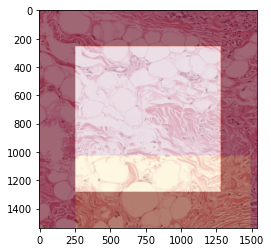

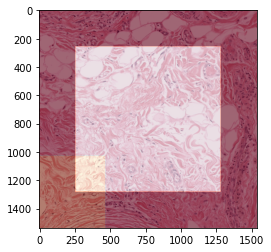

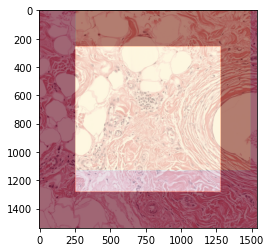

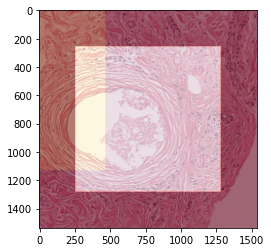

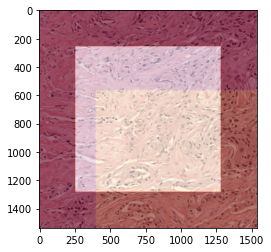

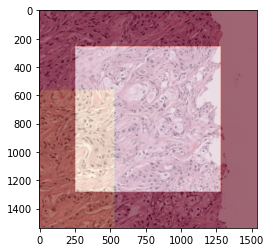

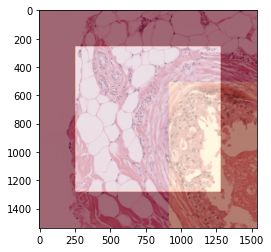

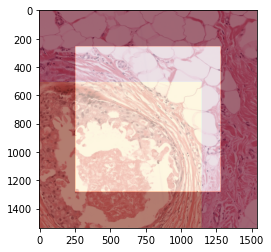

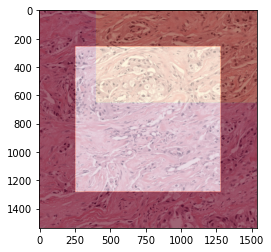

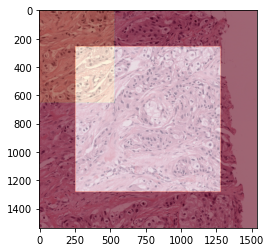

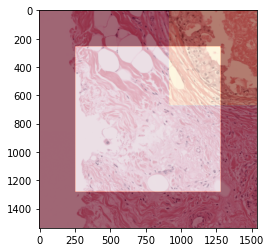

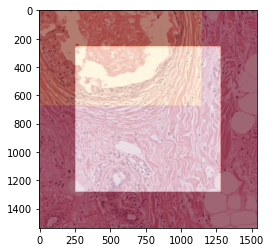

In [8]:
#################################################################
### RUN
#################################################################
training_iterator = create_batch_iterator(config_yml_output_path,
                                          mode,
                                          presets=('slidingwindow.yml',),
                                          cpus=4,
                                          number_of_batches=-1,
                                          return_info=True)

for x_batch, y_batch, info in tqdm(training_iterator):
    ### Get image data, check if new image, save previous image if there was one, if new image create new image file
    sample_reference = info['sample_references'][0]['reference']
    current_file_key = sample_reference.file_key
    if current_file_key != previous_file_key:  # if starting a new image
        if previous_file_key != None and files_exist_already != True:  # if there was a previous image, and the previous image did not exist already (can also be None)
            wsm_writer.save()  # save previous mask
            wsu_writer.save()  # save previous uncertainty
            # Save runtime
            end_time = time.time()
            run_time = end_time - start_time
            text_file = open(output_folder / (image_path.stem + '_runtime.txt'), "w")
            text_file.write(str(run_time))
            text_file.close()
        # Getting file settings and path, doing check if exists already
        with training_iterator.dataset.get_wsi_from_reference(sample_reference) as wsi:
            image_path = wsi.path
            shape = wsi.shapes[wsi.get_level_from_spacing(spacing)]
            real_spacing = wsi.get_real_spacing(spacing)
        wsm_path = output_folder / (image_path.stem + '_nnunet.tif')
        wsu_path = output_folder / (image_path.stem + '_uncertainty.tif')
        if os.path.isfile(wsm_path) and os.path.isfile(wsu_path):
            files_exist_already = True  # this means we can skip this whole loop for this file key, checked above '### Prep, predict and uncertainty'
            previous_file_key = current_file_key
            print(f'[SKIPPING] files for {image_path.stem} exist already')
            # continue  # continue to next batch
        else:
            files_exist_already = False
        # Create new writer and file
        start_time = time.time()
        wsm_writer = WholeSlideMaskWriter()  # whole slide mask
        wsu_writer = WholeSlideMaskWriter()  # whole slide uncertainty
        # Create files
        wsm_writer.write(path=wsm_path, spacing=real_spacing, dimensions=shape,
                         tile_shape=(output_patch_size, output_patch_size))
        wsu_writer.write(path=wsu_path, spacing=real_spacing,
                         dimensions=shape, tile_shape=(output_patch_size, output_patch_size))

    # if files_exist_already:
    #     continue

    plt.imshow(x_batch[0])
    plt.imshow(y_batch[0], alpha=0.2)
    plt.imshow(outer, cmap=cmap, alpha=0.5)  
    plt.show()
        
#     ### Trim check
#     trim_top_idx, trim_bottom_idx, trim_left_idx, trim_right_idx = get_trim_indexes(y_batch)
#     x_batch_maybe_trimmed = x_batch[:, trim_top_idx : trim_bottom_idx, trim_left_idx: trim_right_idx, :]
#     y_batch_maybe_trimmed = y_batch[:, trim_top_idx : trim_bottom_idx, trim_left_idx: trim_right_idx]
#     outer_maybe_trimmed = outer[trim_top_idx : trim_bottom_idx, trim_left_idx: trim_right_idx]
    
#     plt.imshow(x_batch_maybe_trimmed[0])
#     plt.imshow(y_batch_maybe_trimmed[0], alpha=0.2)
#     plt.imshow(outer_maybe_trimmed, cmap=cmap, alpha=0.5)
#     plt.show()
    
    
    
    
    ### Prep, predict and uncertainty
#     prep = norm(x_batch_maybe_trimmed)

#     softmax_list = ensemble_softmax_list(prep)
#     softmax_mean = np.array(softmax_list).mean(0)
#     pred_output_maybe_trimmed = softmax_mean.argmax(axis=-1)

#     uncertainty = softmax_list_and_mean_to_uncertainty(softmax_list, softmax_mean)
#     uncertainty_output_maybe_trimmed = np.array((uncertainty.clip(0, 4) / 4 * 255).int()) 

#     ### Reconstruct possible trim
#     pred_output = np.zeros((sampler_patch_size, sampler_patch_size))
#     pred_output[trim_top_idx : trim_bottom_idx, trim_left_idx: trim_right_idx] = pred_output_maybe_trimmed

#     uncertainty_output = np.zeros((sampler_patch_size, sampler_patch_size))
#     uncertainty_output[trim_top_idx: trim_bottom_idx, trim_left_idx: trim_right_idx] = uncertainty_output_maybe_trimmed

#     # Only write inner part
#     pred_output_inner = crop_data(pred_output, [output_patch_size, output_patch_size])
#     uncertainty_output_inner = crop_data(uncertainty_output, [output_patch_size, output_patch_size])
#     y_batch_inner = crop_data(y_batch[0], [output_patch_size, output_patch_size]).astype('int64')
    
#     ### Get patch point
#     point = info['sample_references'][0]['point']
#     c, r = point.x - output_patch_size/2, point.y - output_patch_size/2 # from middle point to upper left point of tile to write
    
#     ### Write tile and set previous file key for next loop check
#     wsm_writer.write_tile(tile=pred_output_inner, coordinates=(int(c), int(r)), mask=y_batch_inner)
#     wsu_writer.write_tile(tile=uncertainty_output_inner, coordinates=(int(c), int(r)), mask=y_batch_inner)
#     previous_file_key = current_file_key

# wsm_writer.save()  # if done save last image
# wsu_writer.save()  # if done save last image

# # Save runtime
# end_time = time.time()
# run_time = end_time - start_time
# text_file = open(output_folder / (image_path.stem + '_runtime.txt'), "w")
# text_file.write(str(run_time))
# text_file.close()

# training_iterator.stop()
# print("DONE")

# #################################################################
# ### SUBMIT JOB
# #################################################################
# # ~/c-submit --require-cpus=8 --require-mem=32g --gpu-count=1 --require-gpu-mem=10G --priority=low 'joepbogaerts' 9974 48 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 python3 /data/pathology/projects/pathology-lung-TIL/pathology-lung-TIL/code/nnUNet_run_WSI_inference_borderless_TIGER.py

# # ~/c-submit --require-cpus=8 --require-mem=32g --gpu-count=1 --require-gpu-mem=10G --priority=high --constraint=Turing 'joepbogaerts' 9974 48 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 python3 /data/pathology/projects/pathology-lung-TIL/pathology-lung-TIL/code/nnUNet_run_WSI_inference_borderless_TIGER.py